In [177]:
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.ensemble import ExtraTreesClassifier



In [178]:
data = pd.read_csv('Volve_final_prod_data.csv')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data = data.fillna(0)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15634 entries, 0 to 15633
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DATEPRD                   15634 non-null  object 
 1   WELL_BORE_CODE            15634 non-null  object 
 2   AVG_DOWNHOLE_PRESSURE     15634 non-null  float64
 3   AVG_DOWNHOLE_TEMPERATURE  15634 non-null  float64
 4   AVG_DP_TUBING             15634 non-null  float64
 5   AVG_ANNULUS_PRESS         15634 non-null  float64
 6   AVG_CHOKE_SIZE_P          15634 non-null  float64
 7   AVG_WHP_P                 15634 non-null  float64
 8   AVG_WHT_P                 15634 non-null  float64
 9   DP_CHOKE_SIZE             15634 non-null  float64
 10  BORE_OIL_VOL              15634 non-null  float64
 11  BORE_GAS_VOL              15634 non-null  float64
 12  BORE_WAT_VOL              15634 non-null  float64
dtypes: float64(11), object(2)
memory usage: 1.6+ MB


In [179]:
#Clean the data, drop the two wells and drop where all output is zero
well_array = ['NO 15/9-F-1 C', 'NO 15/9-F-11 H', 'NO 15/9-F-12 H','NO 15/9-F-14 H', 'NO 15/9-F-15 D']
data = data.loc[data['WELL_BORE_CODE'].isin(well_array)]
data['WELL_BORE_CODE'].unique()

array(['NO 15/9-F-1 C', 'NO 15/9-F-11 H', 'NO 15/9-F-12 H',
       'NO 15/9-F-14 H', 'NO 15/9-F-15 D'], dtype=object)

In [180]:
well_dictionary ={'NO 15/9-F-1 C': 'Flank', 'NO 15/9-F-11 H':'Flank', 'NO 15/9-F-12 H':'Crest',
                  'NO 15/9-F-14 H':'Crest', 'NO 15/9-F-15 D':'Flank'} 
  
# Add a new column named 'WELL_POS' 
data['WELL_POS'] = data['WELL_BORE_CODE'].map(well_dictionary) 
data.head()

,DATEPRD,WELL_BORE_CODE,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,WELL_POS
0,4/7/2014,NO 15/9-F-1 C,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,Flank
1,4/8/2014,NO 15/9-F-1 C,0.00,0.00,0.00,0.0,1.00,0.0,0.00,0.00,0.0,0.0,0.0,Flank
2,4/9/2014,NO 15/9-F-1 C,0.00,0.00,0.00,0.0,0.98,0.0,0.00,0.00,0.0,0.0,0.0,Flank
3,4/10/2014,NO 15/9-F-1 C,0.00,0.00,0.00,0.0,0.55,0.0,0.00,0.00,0.0,0.0,0.0,Flank
4,4/11/2014,NO 15/9-F-1 C,310.38,96.88,277.28,0.0,1.22,33.1,10.48,33.07,0.0,0.0,0.0,Flank


In [181]:
df= data.drop(data[(data["BORE_OIL_VOL"] == 0) & (data["BORE_GAS_VOL"] == 0) & (data["BORE_WAT_VOL"] == 0)].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7882 entries, 15 to 8927
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DATEPRD                   7882 non-null   object 
 1   WELL_BORE_CODE            7882 non-null   object 
 2   AVG_DOWNHOLE_PRESSURE     7882 non-null   float64
 3   AVG_DOWNHOLE_TEMPERATURE  7882 non-null   float64
 4   AVG_DP_TUBING             7882 non-null   float64
 5   AVG_ANNULUS_PRESS         7882 non-null   float64
 6   AVG_CHOKE_SIZE_P          7882 non-null   float64
 7   AVG_WHP_P                 7882 non-null   float64
 8   AVG_WHT_P                 7882 non-null   float64
 9   DP_CHOKE_SIZE             7882 non-null   float64
 10  BORE_OIL_VOL              7882 non-null   float64
 11  BORE_GAS_VOL              7882 non-null   float64
 12  BORE_WAT_VOL              7882 non-null   float64
 13  WELL_POS                  7882 non-null   object 
dtypes: floa

In [11]:
#df.to_csv('All_wells_final3.csv')

In [182]:
#Downhole Pressure influences downhole temp and DP Tubing
#Avg wellhead oressure and temp are related
df1 = df[['AVG_WHP_P','AVG_CHOKE_SIZE_P','BORE_OIL_VOL','AVG_ANNULUS_PRESS']]
feature_names = df1.columns
df1.head()

,AVG_WHP_P,AVG_CHOKE_SIZE_P,BORE_OIL_VOL,AVG_ANNULUS_PRESS
15,107.36,43.34,631.47,0.0
16,99.19,47.17,1166.46,0.0
17,94.60,47.73,1549.81,0.0
18,89.99,48.53,1248.70,0.0
19,84.78,49.84,1345.78,0.0


In [183]:
feature_names

Index(['AVG_WHP_P', 'AVG_CHOKE_SIZE_P', 'BORE_OIL_VOL', 'AVG_ANNULUS_PRESS'], dtype='object')

In [184]:
X = df1
y = df['AVG_DOWNHOLE_PRESSURE'].values.reshape(-1,1)

In [185]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [186]:
X_train.shape

(5911, 4)

In [187]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler().fit(X_train)
X_train_s = x_scaler.transform(X_train)
X_test_s = x_scaler.transform(X_test)

In [188]:
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler().fit( y_train)
y_train_s = y_scaler.transform( y_train)
y_test_s = y_scaler.transform(y_test)

In [189]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_s, y_train_s)
score = model.score(X_test_s, y_test_s)
print(f"R2 Score: {score}")

R2 Score: 0.15605347112858214


In [190]:
from sklearn.metrics import mean_squared_error, r2_score
predicted_train = model.predict(X_test_s)
# YOUR CODE HERE
# Score the prediction with mse and r2
mse = mean_squared_error(y_test_s, predicted_train)
r2 = r2_score(y_test_s, predicted_train)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 0.8709468826189709
R-squared (R2 ): 0.15605347112858214


In [191]:
# Call the `score` method on the model to show the r2 score
model.score(X_test_s, y_test_s)

0.15605347112858214

In [192]:
importances = model.coef_
importances

array([[ 0.02732628, -0.23448922,  0.19973982, -0.16917728]])

In [193]:
importances,feature_names

(array([[ 0.02732628, -0.23448922,  0.19973982, -0.16917728]]),
 Index(['AVG_WHP_P', 'AVG_CHOKE_SIZE_P', 'BORE_OIL_VOL', 'AVG_ANNULUS_PRESS'], dtype='object'))

Text(0.5, 1.0, 'Residual Plot')

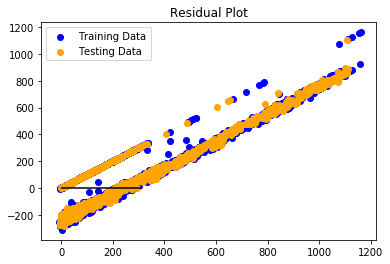

In [194]:
# Plot the Residuals for the Training and Testing data

### BEGIN SOLUTION
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")

NON-LINEAR REGRESSION

In [213]:
df1['BORE_OIL_VOL_sq']=df1['BORE_OIL_VOL']**2
df1.head()

C:\Users\RAKHI\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,AVG_WHP_P,AVG_CHOKE_SIZE_P,BORE_OIL_VOL,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P_sq,BORE_OIL_VOL_sq
15,107.36,43.34,631.47,0.0,1878.3556,3.987544e+05
16,99.19,47.17,1166.46,0.0,2225.0089,1.360629e+06
17,94.60,47.73,1549.81,0.0,2278.1529,2.401911e+06
18,89.99,48.53,1248.70,0.0,2355.1609,1.559252e+06
19,84.78,49.84,1345.78,0.0,2484.0256,1.811124e+06


In [214]:
df2 = df1[['AVG_CHOKE_SIZE_P','AVG_WHP_P','BORE_OIL_VOL_sq','AVG_ANNULUS_PRESS']]
df2.head()


,AVG_CHOKE_SIZE_P,AVG_WHP_P,BORE_OIL_VOL_sq,AVG_ANNULUS_PRESS
15,43.34,107.36,3.987544e+05,0.0
16,47.17,99.19,1.360629e+06,0.0
17,47.73,94.60,2.401911e+06,0.0
18,48.53,89.99,1.559252e+06,0.0
19,49.84,84.78,1.811124e+06,0.0


In [215]:
feature_names_2=df2.columns
feature_names_2

Index(['AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'BORE_OIL_VOL_sq',
       'AVG_ANNULUS_PRESS'],
      dtype='object')

In [216]:
X = df2
y = df['AVG_DOWNHOLE_PRESSURE'].values.reshape(-1,1)

In [217]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [218]:
X_train.shape

(5911, 4)

In [219]:
y_train.shape

(5911, 1)

In [220]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler().fit(X_train)
X_train_s = x_scaler.transform(X_train)
X_test_s = x_scaler.transform(X_test)

In [221]:
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler().fit( y_train)
y_train_s = y_scaler.transform( y_train)
y_test_s = y_scaler.transform(y_test)

In [222]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_s, y_train_s)
score = model.score(X_test_s, y_test_s)
print(f"R2 Score: {score}")

R2 Score: 0.15226953711540725


In [223]:
from sklearn.metrics import mean_squared_error, r2_score
predicted_train = model.predict(X_test_s)
# YOUR CODE HERE
# Score the prediction with mse and r2
mse = mean_squared_error(y_test_s, predicted_train)
r2 = r2_score(y_test_s, predicted_train)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

Mean Squared Error (MSE): 0.8748518759095029
R-squared (R2 ): 0.15226953711540725


In [224]:
# Call the `score` method on the model to show the r2 score
model.score(X_test_s, y_test_s)

0.15226953711540725

In [225]:
importances = model.coef_
importances

array([[-0.21860248,  0.07181687,  0.1598229 , -0.18022871]])

In [226]:
importances,feature_names_2

(array([[-0.21860248,  0.07181687,  0.1598229 , -0.18022871]]),
 Index(['AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'BORE_OIL_VOL_sq',
        'AVG_ANNULUS_PRESS'],
       dtype='object'))